In [1]:
from numpy.linalg import norm
import numpy as np
import os
import os.path
from os import path
import sys
import glob
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px
import hdbscan
import pandas as pd
import umap
from graviti import *
import networkx as nx
from scipy import sparse, linalg
import warnings
warnings.filterwarnings('ignore')

In [13]:
def mm(A,times): # multiply A times-times
    if times > 0:
        M = A.dot(A)
    else:
        M = A
    for t in range(1,times):
        newM = A.dot(M)
        M = newM
    return M

def covd2vec(row_ID, row_idx, col_idx, data, A):
    mask = row_idx == row_ID # the non-zero elements idx at row rowID
    a = A[row_ID,col_idx[mask]] # the non-zero elements entries at row rowID, representing the weight of the node j morphology wrt node i
    morphology = data[col_idx[mask],:] # get the morphologies of the nodes path-connected to row_ID
    morphology = np.vstack((data[row_ID,:],morphology)) # add the row_ID node
    a = np.hstack(([1],a.data)) # add the weight of the local node 
    C = np.cov(morphology,rowvar=False,aweights=a) # the covd for row_ID weighted with paths
    iu1 = np.triu_indices(C.shape[1]) # the indices of the upper triangular part
    vec = C[iu1]
    #descriptor[row_ID,:]
    return vec

def covd_nn(A,data): # given graph and morphological data returns a descriptor averaged with the nearest neightbors
    row_idx, col_idx = A.nonzero()
    dim = int(0.5*data.shape[1]*(data.shape[1]+1)) # size of the covd descriptor
    #descriptor = np.zeros((data.shape[0],dim))
    descriptor = [covd2vec(row_ID, row_idx, col_idx, data, A) for row_ID in range(A.shape[0])]
    return np.asarray(descriptor)

In [3]:
dirname = '../h5/id_52/' # the path to *features.npz files 
sample = '52' #sys.argv[2]  # the sample id

counter = 0
for f in glob.glob(dirname+'/*features.npz'): # for every fov
    counter += 1
    if counter == 1:            # set up the data arrays
        data = np.load(f,allow_pickle=True)
        fov = data['fov']
        xy = data['centroids']
        morphology = data['morphology']
    else:                       # update the data arrays
        data = np.load(f,allow_pickle=True)
        fov = np.vstack((fov,data['fov']))
        xy = np.vstack((xy, data['centroids']))
        morphology = np.vstack((morphology, data['morphology']))

# Create dataframes with spatial and morphological measurements
df_fov = pd.DataFrame(data=fov, columns=['fov_row','fov_col'])
df_xy = pd.DataFrame(data=xy, columns=['cx','cy'])
df_morphology = pd.DataFrame(data=morphology, columns=['area','perimeter','solidity','eccentricity','circularity','mean_intensity','std_intensity'])

# Concatenate all dataframes
df = pd.concat([df_fov,df_xy, df_morphology],axis=1)

In [20]:
# filter by percentiles in morphologies (hardcoded in function filtering) and introduce coeff. of var
fdf = filtering(df).sample(n=100000)

In [21]:
# Get the positions of centroids 
pos = fdf[fdf.columns[2:4]].to_numpy()
nn = 10 # set the number of nearest neighbor in the umap-graph. Will be used in CovD as well

# Building the UMAP graph
filename = '../py/'+str(sample)+'.graph.npz' # the adj sparse matrix
if False:#path.exists(filename):
    print('The graph already exists')
    A = sparse.load_npz(filename) 
else:
    print('Creating the graph')
    A = space2graph(pos,nn)
    sparse.save_npz(filename, A)
    
filename = '../py/'+str(sample)+'.graph.pickle'    # the networkx obj
if False:#path.exists(filename):    
    print('The network already exists')
    G = nx.read_gpickle(filename)
else:
    print('Creating the network')
    G = nx.from_scipy_sparse_matrix(A, edge_attribute='weight')
    nx.write_gpickle(G, filename)

Creating the graph
Creating the network


In [22]:
features = ['area',
            'perimeter',
            'solidity',
            'eccentricity',
            'circularity',
            'mean_intensity',
            'std_intensity',
            'cov_intensity']
data = fdf[features].to_numpy()

In [23]:
descriptor = covd_nn(A,data) # covd descriptors of the connected nodes
descriptor.shape

KeyboardInterrupt: 

In [63]:
L = nx.laplacian_matrix(G, weight='weight') # get the Laplacian matrix
delta_descriptor = L.dot(descriptor) # get the local differianted descriptor
delta = norm(delta_descriptor,axis=1) # get the norm of the differential field

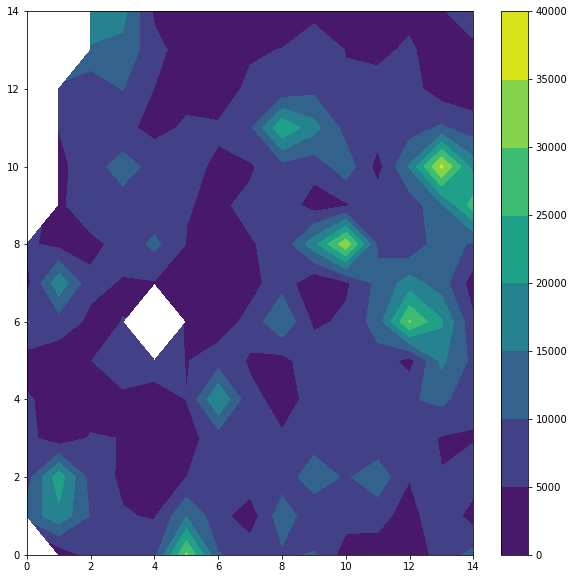

In [69]:
N = 15 # number of linear bins

fdf['field'] = delta # define the laplacian field
fdf['x_bin'] = pd.cut(fdf['cx'], N, labels=False) # define the x bin label
fdf['y_bin'] = pd.cut(fdf['cy'], N, labels=False) # define the y bin label

# define the pivot tabel for the contour plot
table = pd.pivot_table(fdf, 
                       values='field', 
                       index=['x_bin'],
                       columns=['y_bin'],
                       aggfunc=np.mean,
                       fill_value=None)

X=table.columns.values
Y=table.index.values
Z=table.values
Xi,Yi = np.meshgrid(X, Y)
fig, ax = plt.subplots(figsize=(10,10))
cs = ax.contourf(Yi, Xi, Z, alpha=1.0, cmap=plt.cm.viridis);
cbar = fig.colorbar(cs)
plt.savefig('test.png')